# Calculate the reaction rates for the primary reactions, as well as the main secondary reactions

In [1]:

from utils import *
import numpy as np
import matplotlib.pyplot as plt

# Calculate Startup Time and Net Power Loss

In [2]:
# Input Data
V_plasma = 150 * unit.m**3  # Plasma volume [m^3]
n_e_avg = 1.7e20 * unit.m**-3  # Average electron density [1/m^3]
n_D = n_e_avg  # Deuterium density, same as electron density initially [1/m^3]
#Pf_DT = 1000 * unit.MW  # Fusion power for DT reactor [MW]
T_e_avg = 14 * unit.keV  # Average electron temperature [keV]
I_ST = 3 * unit.kg  # Inventory target [kg]

# PARAMETERS FOR THE FUSION REACTION
tau_p_T = 1 * unit.s  # Tritium confinement time [s]
tau_p_He3 = 1 * unit.s # He3 confinement time [s]

# PARAMETERS FOR THE TRITIUM PRODUCTION
TBR = 1.15  # Tritium breeding ratio for DT neutrons [-]
TBR_DDn = 1  # Tritium breeding ratio for DD neutrons [-]

# PARAMETERS FOR THE NET POWER LOSS
eta_th = 0.3  # Thermal efficiency of the reactor [-]
Q = 9  # Fusion gain factor [-] Q = (Pfus-Paux)/Paux
P_aux = 100 * unit.MW  # Auxiliary heating power [MW]
Cost_per_MWh = 0.25/unit('kWh') # [USD] is the cost of electricity

In [3]:
# Calculate the reaction rates
DD_reaction_rates = calculate_reaction_rates_DD(n_D, T_e_avg, V_plasma, tau_p_T, tau_p_He3)
# Print the dictionary in the desired format with scientific notation and pretty units
print("Reaction Rates:")
for key, value in DD_reaction_rates.items():
    if hasattr(value, "magnitude"):  # Check if the value is a pint.Quantity
        print(f"{key}: {value:.2e~P}")
    else:
        print(f"{key}: {value:.2e}")

Reaction Rates:
R_DDp: 2.62×10¹⁸ 1/s
R_DDn: 2.78×10¹⁸ 1/s
R_DT: 1.03×10¹⁷ 1/s
R_DHe3: 4.22×10¹⁴ 1/s
R_tot: 5.50×10¹⁸ 1/s
density_T: 1.68×10¹⁶ 1/m³
density_He3: 1.85×10¹⁶ 1/m³
prob_DDp: 4.76×10⁻¹
prob_DDn: 5.05×10⁻¹
prob_DT: 1.87×10⁻²
prob_DHe3: 7.66×10⁻⁵
prob_tot: 1.00×10⁰


## Estimate Tritium production

In [4]:
# calculate the tritium production rates
Tdot_DD_plasma = DD_reaction_rates["R_DDp"] # [1/s] is the rate of tritium production due to DDp fusions
Tdot_fusion = DD_reaction_rates["R_DDp"] - DD_reaction_rates["R_DT"] # [1/s] rate of tritium production due to DDp fusions, considering the losses due to DT fusions
Tdot_diff = V_plasma * DD_reaction_rates["density_T"] / tau_p_T # [1/s] is the rate of tritium production due to diffusion of tritium in the breeding blanket
Tdot_breedingDT = TBR * DD_reaction_rates["R_DT"] # [1/s] is the rate of tritium production due to DT neutrons interacting with the breeding blanket
Tdot_breedingDD = TBR_DDn * DD_reaction_rates["R_DDn"] # [1/s] is the rate of tritium production due to DD neutrons interacting with the Li6 in the breeding blanket
Tdot_tot = Tdot_fusion + Tdot_breedingDT + Tdot_breedingDD # [1/s] is the total rate of tritium production in the system

"""
            |----> He3 + n (2.45 MeV)
            |            |--------------------> Tdot_breedingDD: tritium production due to DD neutrons interacting with the Li6 in the breeding blanket
    D + D ->|
      |     |----> T + p
      |            |
      |------------|---> D + T --> He4 + n (14.1 MeV)
                   |                     |----> Tdot_breedingDT: tritium production due to DT neutrons interacting with the breeding blanket
                   |
                   |--------------------------> Tdot_fusion: tritium production due to DDp fusions, considering the losses due to DT neutrons (NB. It is assumed that all the Tritium that is not burnt in DT fusios can be extracted from the system)
"""

print(f"tritium production rates:\n",
      f"    {Tdot_DD_plasma:.2e~P}: tritum produced from the DDp channel\n",
      f"    {Tdot_fusion:.2e~P}: tritium produced in the DDp channel and not burnt\n",
      f"    {Tdot_diff:.2e~P} from the diffusion of tritium (should be equal to the tritium produced in the DDp channel and not burnt)\n",
      f"    {Tdot_breedingDT:.2e~P} from the 14.1 MeV neutrons produced in the DT subchannel and bred (TBR = {TBR})\n",
      f"    {Tdot_breedingDD:.2e~P} from the 2.45 MeV neutrons produced in the DDn channel and bred (TBR_DDn = {TBR_DDn})\n",
      f"    --------------\n",
      f"    {Tdot_tot:.2e~P} total rate of tritium production in the system")

print(f"density of tritium: {DD_reaction_rates['density_T']:.2e~P} [1/m^3]")


tritium production rates:
     2.62×10¹⁸ 1/s: tritum produced from the DDp channel
     2.52×10¹⁸ 1/s: tritium produced in the DDp channel and not burnt
     2.52×10¹⁸ 1/s from the diffusion of tritium (should be equal to the tritium produced in the DDp channel and not burnt)
     1.18×10¹⁷ 1/s from the 14.1 MeV neutrons produced in the DT subchannel and bred (TBR = 1.15)
     2.78×10¹⁸ 1/s from the 2.45 MeV neutrons produced in the DDn channel and bred (TBR_DDn = 1)
     --------------
     5.41×10¹⁸ 1/s total rate of tritium production in the system
density of tritium: 1.68×10¹⁶ 1/m³ [1/m^3]


## Startup time
the inventory of tritium is affected both by production  (Tdot_tot) and by losses due to decay  
then I(t) = Tdot_tot/lambda (1-exp(-lambda*t))  
and t_ST = -(1/lambda_T) * np.log(1 - (N_ST * lambda_T / Tdot_tot))                 # N_ST is I_ST in atoms instead of kg  

### BE CAREFUL! the startup time may go to infinity if conditions are not well imposed

In [5]:
# the inventory of tritium is affected both by production  (Tdot_tot) and by losses due to decay
# then I(t) = Tdot_tot/lambda (1-exp(-lambda*t))

#find the time needed to reach the inventory target
lambda_T = np.log(2) / ((12.32 * unit.year).to('s'))  # Tritium decay constant [1/s]
print(f"Tritium decay constant: {lambda_T.to('1/year'):.2e~P}")
# CALCULATE THE STARTUP TIME
N_ST = I_ST/molecular_weight_T.to("kg/mol")*N_A # [-] is the number of tritium atoms needed for startup (I_ST[g]/3.016[g/mol]*6.022e23[atoms/mol])
lambda_T = np.log(2) / ((12.32 * unit.year).to('s'))  # Tritium decay constant [1/s]
ratio = N_ST * lambda_T / Tdot_tot  # [-] is the ratio of the number of tritium atoms needed for startup to the total rate of tritium production
if ratio >= 1:
    startup_time = np.inf * unit.s # or np.nan if you prefer
else:
    startup_time = - (1/lambda_T) * np.log(1 - (ratio))  # Time to reach the inventory target [s]
           

# Print the startup time in different units using pint's conversion methods
print(f"Startup time: {startup_time:.2e~P} ({startup_time.to('hour'):.2e~P} = {startup_time.to('day'):.2e~P} = {startup_time.to('year'):.2e~P})")

Tritium decay constant: 5.63×10⁻² 1/a
Startup time: 1.23×10⁸ s (3.42×10⁴ h = 1.43×10³ d = 3.91×10⁰ a)


In [6]:
startup_time_old = N_ST / Tdot_tot  # Old formula for startup time [s] - does not consider decay
print(f"Startup time (old formula): {startup_time_old:.2e~P} [s] = {startup_time_old.to('hour'):.2e~P} = {startup_time_old.to('day'):.2e~P} = {startup_time_old.to('year'):.2e~P}")

Startup time (old formula): 1.11×10⁸ s [s] = 3.07×10⁴ h = 1.28×10³ d = 3.51×10⁰ a


## Calculate Fusion Power

In [7]:
# Calculate the Reactor Power for DD reactions

Pf_DD = DD_reaction_rates["R_DDp"]*E_DDp + DD_reaction_rates["R_DDn"]*E_DDn # [W] is the power produced by DD reactions
Pf_DD_DT = DD_reaction_rates["R_DT"]*E_DT # [W] is the power produced by DT sub-reactions
Pf_DD_DHe3 = DD_reaction_rates["R_DHe3"]*E_DHe3 # [W] is the power produced by DHe3 sub-reactions
Pf_DD_tot = Pf_DD.to('MW') + Pf_DD_DT.to('MW') + Pf_DD_DHe3.to('MW') # [W] is the total power produced in a DD reactor
print(f"Pf_DD_tot: {Pf_DD_tot:.2f~P} \n(of which {Pf_DD.to('MW'):.2f~P} is from DD reactions, {Pf_DD_DT.to('MW'):.2f~P} is from DT sub-reactions and {Pf_DD_DHe3.to('MW'):.2f~P} is from DHe3 sub-reactions)")

Pf_DT = fusion_power_50D50T(n_e_avg, T_e_avg, E_DT, V_plasma) # [W] is the power produced by DT reactions (the 1e-6 factor is needed to convert <sigmav> from cm^3/s to m^3/s)
# N.B. this is the total fusion power of a 50%D-50%T plasma in the selected conditions - it may not correspond to the expected 1000 MW power due to the use of average values of T and n_e
print(f"Pf_DT: {Pf_DT.to('MW'):.2f~P}\n(considering a 50%D-50%T plasma and using the formula (n_e_avg/2)^2 * <sigmav>_DT * E_DT * V_plasma)")


Pf_DD_tot: 3.52 MW 
(of which 3.23 MW is from DD reactions, 0.29 MW is from DT sub-reactions and 0.00 MW is from DHe3 sub-reactions)
Pf_DT: 735.10 MW
(considering a 50%D-50%T plasma and using the formula (n_e_avg/2)^2 * <sigmav>_DT * E_DT * V_plasma)


## Calculate net power loss

In [8]:
"""
The net power may be calculated either by fixing the Q or the P_aux
As can be expected, imposing an advantageous Q results in a lower P_aux
Fixing P_aux may be a more realistich approach, as it is a more direct way to control the reactor power
"""

P_e_net_DD, Q_DD = calculate_P_e_net_Paux(Pf_DD, P_aux, eta_th) # [W] is the net electrical power produced by the reactor
P_e_net_DDQ, P_auxDDQ = calculate_P_e_net_Q(Pf_DD, Q, eta_th) # [W] is the net electrical power produced by the reactor
P_e_net_DT, Q_DT = calculate_P_e_net_Paux(Pf_DT, P_aux, eta_th) # [W] is the net electrical power produced by the reactor
P_e_net_DTQ, P_auxDTQ = calculate_P_e_net_Q(Pf_DT, Q, eta_th) # [W] is the net electrical power produced by the reactor
print(f"P_e_net_DD: {P_e_net_DD.to('MW'):.2f~P}, Q_DD: {Q_DD.to(''):.2f~P}, P_aux(imposed): {P_aux.to('MW'):.2f~P}")
print(f"P_e_net_DDQ: {P_e_net_DDQ.to('MW'):.2f~P}, Q(imposed): {Q}, P_aux: {P_auxDDQ.to('MW'):.2f~P}")
print(f"P_e_net_DT: {P_e_net_DT.to('MW'):.2f~P}, Q_DT: {Q_DT.to(''):.2f~P}, P_aux(imposed): {P_aux.to('MW'):.2f~P}")
print(f"P_e_net_DTQ: {P_e_net_DTQ.to('MW'):.2f~P}, Q(imposed): {Q}, P_aux: {P_auxDTQ.to('MW'):.2f~P}")


# Condsider P_aux fixed for both the DD and DT reactions
E_lost = np.abs(P_e_net_DD*startup_time - P_e_net_DT*startup_time) # [J] is the energy lost during the startup time operation in DD

print(f"E_lost: {E_lost.to('MJ'):.2e~P}")

Dollar_lost = Cost_per_MWh.to('1/J') * E_lost # [USD] is the cost of the lost energy during the startup time operation in DD
print(f"$ lost: {Dollar_lost:.2f~P} USD = {Dollar_lost/1e9:.2f~P} billion USD")

P_e_net_DD: -99.03 MW, Q_DD: -0.97, P_aux(imposed): 100.00 MW
P_e_net_DDQ: 0.65 MW, Q(imposed): 9, P_aux: 0.32 MW
P_e_net_DT: 120.53 MW, Q_DT: 6.35, P_aux(imposed): 100.00 MW
P_e_net_DTQ: 147.02 MW, Q(imposed): 9, P_aux: 73.51 MW
E_lost: 2.71×10¹⁰ MJ
$ lost: 1879064233.31 USD = 1.88 billion USD


# Use profiles to estimate the fusion power more precisely  


Volume-averaged profile: 1.40×10¹ keV
Volume-averaged profile: 1.70×10²⁰ 1/m³


AttributeError: 'tuple' object has no attribute 'to'

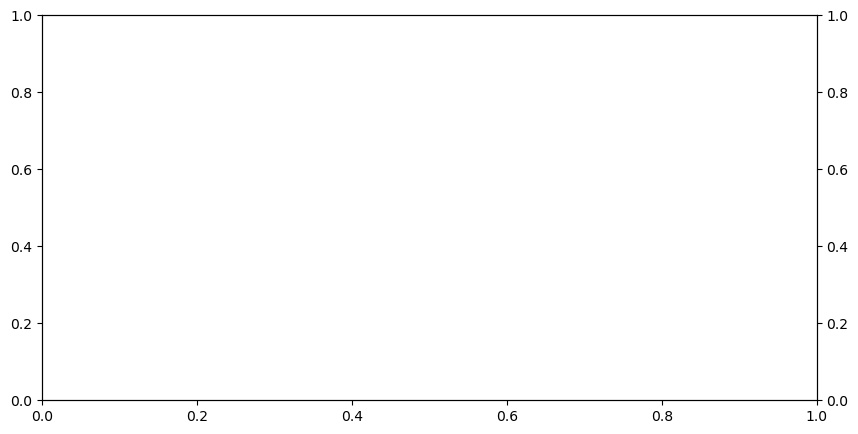

In [9]:
points = 1000  # or your desired resolution
x = np.linspace(0, 1, points)  # Normalized minor radius
# use the T_e_profile disecretized to calculate the sigmavs
T_e = pedestal_profile(x, value_center=25*unit.keV, value_ped=5.5*unit.keV, value_edge=0.01*unit.keV, transition_ratio=0.95)  # [keV] is the electron temperature profile
n_D = pedestal_profile(x, value_center=2.15e20*unit.m**-3, value_ped=1.45e20*unit.m**-3, value_edge=1e19*unit.m**-3, transition_ratio=0.95)  # [1/m^3] is the deuterium density profile


plt.figure(figsize=(10, 5))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(x, T_e.to('keV').magnitude, label='T_e (keV)', color='red')
ax2.plot(x, n_D.to('1/m^3').magnitude, label='n_D (1/m^3)', color='blue')

ax1.set_xlabel('Normalized Minor Radius')
ax1.set_ylabel('T_e (keV)', color='red')
ax2.set_ylabel('n_D (1/m^3)', color='blue')

ax1.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('T_e and n_D Profiles (Different Scales)')
ax1.grid()
plt.show()

pdict = calculate_reaction_rates_DD(n_D, T_e, V_plasma, tau_p_T, tau_p_He3,  points)  # [1/s] is the reaction rate for DD reactions

# Calculate the Reactor Power for DD reactions

Pf_DD = pdict['R_DDp'] * E_DDp + pdict['R_DDn'] * E_DDn  # [W] is the power produced by DD reactions
Pf_DD_DT = pdict['R_DT'] * E_DT  # [W] is the power produced by DT sub-reactions
Pf_DD_DHe3 = pdict['R_DHe3'] * E_DHe3  # [W] is the power produced by DHe3 sub-reactions

Pf_DD_tot = Pf_DD.to('MW') + Pf_DD_DT.to('MW') + Pf_DD_DHe3.to('MW')  # [W] is the total power produced in a DD reactor
print(f"Pf_DD_tot: {Pf_DD_tot:.2f~P} \n(of which {Pf_DD.to('MW'):.2f~P} is from DD reactions, {Pf_DD_DT.to('MW'):.2f~P} is from DT sub-reactions and {Pf_DD_DHe3.to('MW'):.2f~P} is from DHe3 sub-reactions)")


n_e_DT = pedestal_profile(x, value_center=2.15e20*unit.m**-3, value_ped=1.45e20*unit.m**-3, value_edge=1e19*unit.m**-3, transition_ratio=0.95)  # [1/m^3] is the deuterium density profile
pdict_DT = calculate_reaction_rates_DT(n_e_DT, T_e, V_plasma)  # [1/s] is the reaction rate for DD reactions

# Calculate the Reactor Power for DT reactions
Pf_DT = pdict_DT['R_DT'] * E_DT  # [W] is the power produced by DT reactions
print(f"Pf_DT: {Pf_DT.to('MW'):.2f~P} ")